In [131]:
!pip install gpytorch
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt
import neural_process as nep

%matplotlib inline

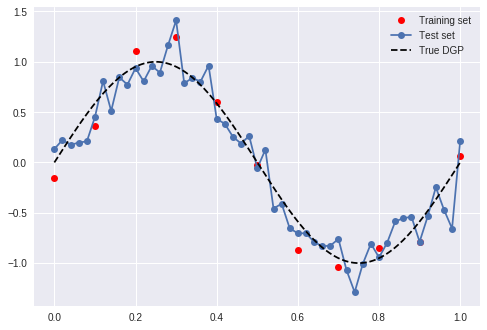

In [132]:
torch.manual_seed(19051994)

# Training data is 11 points in [0,1] inclusive regularly spaced
test_x = torch.linspace(0, 1, 51)
test_y = torch.sin(test_x * (2 * np.pi)) + torch.randn(test_x.size()) * 0.2

truth_x = torch.linspace(0, 1, 150)
truth_y = torch.sin(truth_x * (2 * np.pi))

train_x = torch.linspace(0, 1, 11)
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2


plt.style.use('seaborn')
plt.plot(train_x.numpy(), train_y.numpy(), 'ro')
plt.plot(test_x.numpy(), test_y.numpy(), '-o')
plt.plot(truth_x.numpy(), truth_y.numpy(), 'k--')
plt.legend(['Training set', 'Test set', 'True DGP'])
plt.show()

In [0]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [0]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(params=list(model.parameters()), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x)
    
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

In [0]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

RuntimeError: ignored

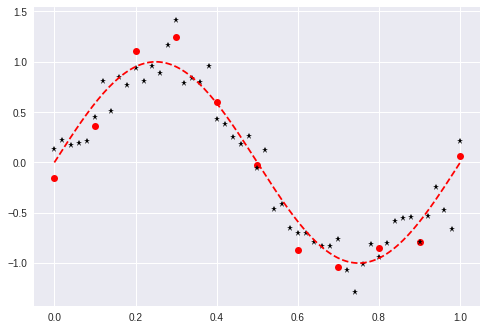

In [207]:
with torch.no_grad():

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    
    # Plot training data as black stars
    plt.plot(train_x.numpy(), train_y.numpy(), 'ro')
    plt.plot(test_x.numpy(), test_y.numpy(), 'k*')
    plt.plot(truth_x.numpy(), truth_y.numpy(), 'r--')
    
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), observed_pred.mean.numpy())
    
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.15, facecolor='#089FFF')
    plt.legend(['Training Set', 'Test Set', 'True DGP', 'Prediction', 'Confidence'])

In [0]:
test_x = test_x.squeeze(-1)
test_y = test_y.squeeze(-1)
train_x = train_x.squeeze(-1)
train_y = train_y.squeeze(-1)

In [0]:
test_x = test_x.unsqueeze(-1)
test_y = test_y.unsqueeze(-1)
train_x = train_x.unsqueeze(-1)
train_y = train_y.unsqueeze(-1)

In [0]:
x_dim = 1
y_dim = 1
r_dim = 3#8
z_dim = 3#8

encoder_specs = [(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), (10, torch.nn.Tanh()),
                 (r_dim, None)]

decoder_specs = [(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), 
                 #(10, torch.nn.Tanh()), (10, torch.nn.Tanh()), (10, torch.nn.Tanh()),
                 (y_dim, None)]

encoder_input_dim = x_dim + y_dim 
decoder_input_dim = x_dim + z_dim

h = nep.Encoder(encoder_input_dim, encoder_specs, init_func=torch.nn.init.kaiming_normal_)
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(decoder_input_dim, decoder_specs, init_func=torch.nn.init.kaiming_normal_)
optimizer = torch.optim.Adam(params=list(g.parameters()) + list(h.parameters()) + list(r_to_z.parameters()), lr=1e-3)

In [0]:
h = nep.Encoder(encoder_input_dim, encoder_specs, init_func=torch.nn.init.kaiming_normal_)
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(decoder_input_dim, decoder_specs, init_func=torch.nn.init.kaiming_normal_)
optimizer = torch.optim.Adam(params=list(g.parameters()) + list(h.parameters()) + list(r_to_z.parameters()), lr=1e-3)

Epoch: 0


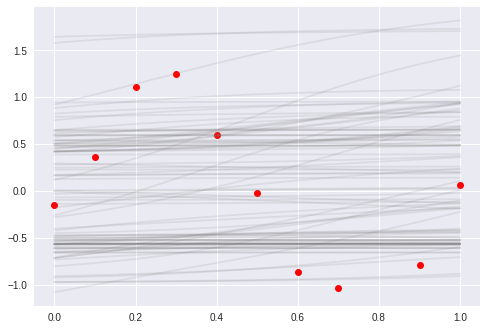

Epoch: 1000


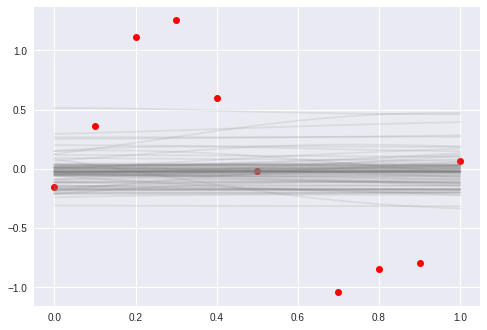

Epoch: 2000


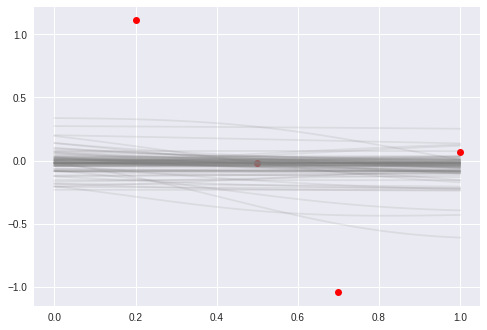

Epoch: 3000


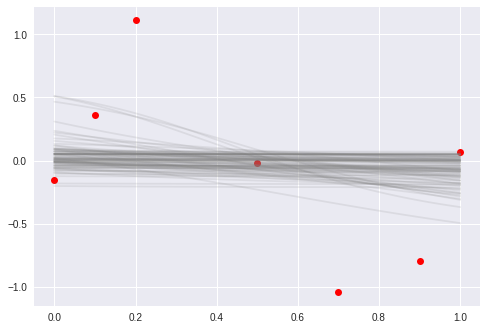

Epoch: 4000


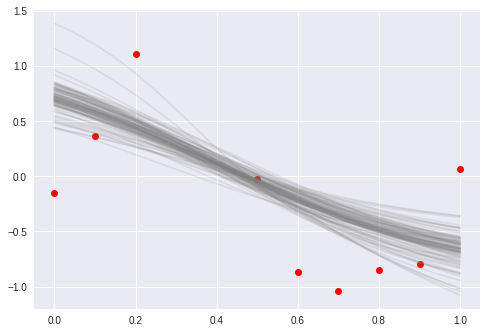

Epoch: 5000


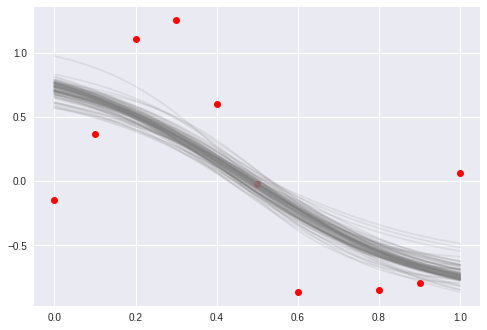

Epoch: 6000


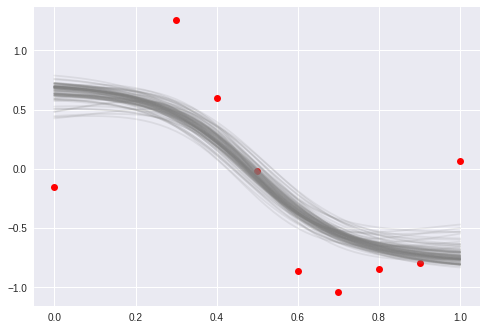

Epoch: 7000


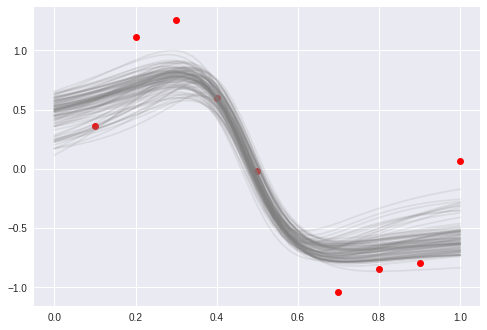

Epoch: 8000


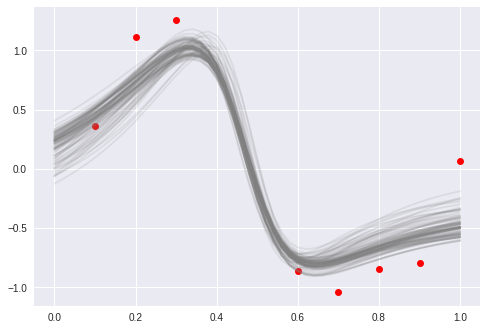

Epoch: 9000


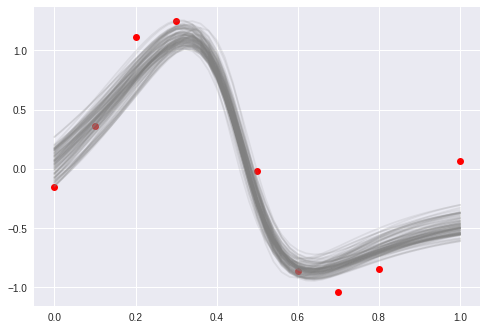

Training successful


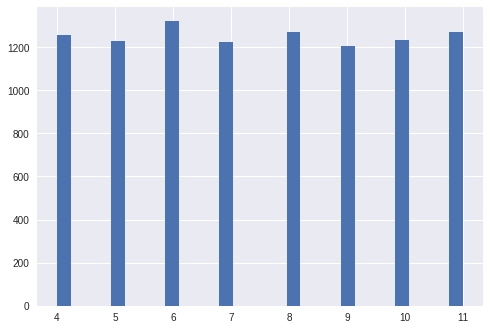

In [194]:
epochs = 10000
kl = []
elbo = []
loss = torch.nn.MSELoss()
compare = []
context_size = []

#TRAINING
for epoch in range(epochs):
    optimizer.zero_grad()
    
    
    # select number of context points randomly
    n_context = np.random.randint(4, 12)
    context_size.append(n_context)
    
    
    # select `n_context` points and create the context set and target set
    context_indeces = np.random.choice(train_x.shape[0], n_context, replace=False)
    x_c = train_x[context_indeces]
    y_c = train_y[context_indeces]
    x_t = train_x
    y_t = train_y

    
    # variational parameters (mean, std) of approximate prior
    z_mean_c, z_std_c = r_to_z(h(x_c, y_c))
    
    # variational parameters (mean, std) of approximate posterior
    z_mean_t, z_std_t = r_to_z(h(x_t, y_t))
   
    z_std_t = 10*z_std_t
    #train1
#     log_likelihood = nep.MC_loglikelihood(x_t, y_t, g, z_mean_t, z_std_t, 10)
    KL = nep.KL_div(z_mean_t, z_std_t, z_mean_c, z_std_c) 
#     ELBO = - log_likelihood + KL
#     kl.append(KL)
#     elbo.append(ELBO)
#     ELBO.backward()
#     optimizer.step()   
    
    #train2
    z = nep.sample_z(z_mean_t, z_std_t, how_many=1)
    y_pred, _ = g(x_t, z)
    output = loss(y_pred, y_t) + KL
    compare.append(output)
    output.backward()
    optimizer.step()   
    
    
    
    if epoch % 1000 == 0:
        print('Epoch:', epoch)
        y_pred = nep.predict(test_x, g, z_mean_t, z_std_t, 100)

        # Plot of sample functions
        plt.plot(x_c.numpy(), y_c.numpy(), 'ro')
        for i in y_pred:
            plt.plot(test_x.numpy(), i, 'grey', alpha=0.15) 
        plt.show()
        
        
print('Training successful')
plt.hist(context_size, 30)
plt.show()

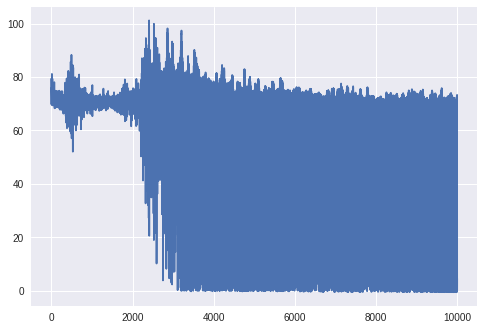

tensor(-0.6077, grad_fn=<AddBackward0>)


In [184]:
plt.plot(compare)
plt.show()
print(min(compare))

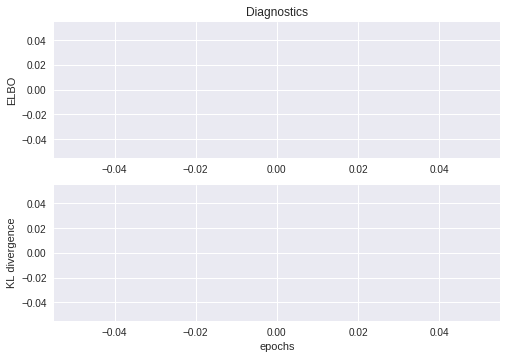

In [143]:
# DIAGNOSTICS
plt.subplot(2,1,1)
plt.plot(elbo)
plt.title('Diagnostics')
plt.ylabel('ELBO')

plt.subplot(2, 1, 2)
plt.plot(kl)
plt.ylabel('KL divergence')
plt.xlabel('epochs')
plt.show()

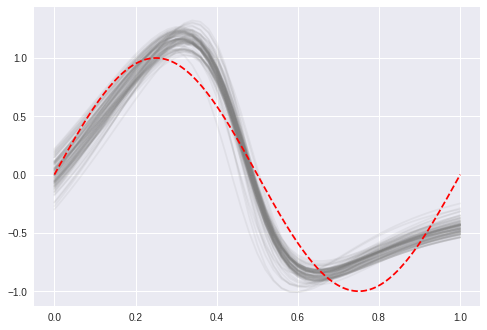

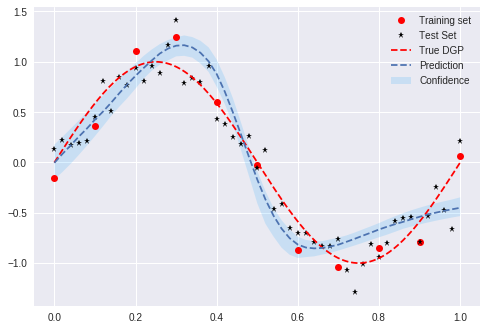

In [195]:
y_pred = nep.predict(test_x, g, z_mean_t, z_std_t, 100)
quantile_05, median, quantile_95 = np.percentile(y_pred, [5, 50, 95], axis=0)

# Plot of sample functions
for i in y_pred:
    plt.plot(test_x.numpy(), i, 'grey', alpha=0.1)   
plt.plot(truth_x.numpy(), truth_y.numpy(), 'r--')
plt.show()
    
    
# Plot of distribution over functions
plt.plot(train_x.numpy(), train_y.numpy(), 'ro')
plt.plot(test_x.numpy().flatten(), test_y.numpy().flatten(), 'k*')
plt.plot(truth_x.numpy(), truth_y.numpy(), 'r--')
plt.plot(test_x.numpy().flatten(), median.flatten(), '--')
plt.fill_between(test_x.numpy().flatten(), quantile_05.flatten(), quantile_95.flatten(), alpha=0.15, facecolor='#089FFF')
plt.legend(['Training set', 'Test Set', 'True DGP', 'Prediction', 'Confidence'])
plt.show()

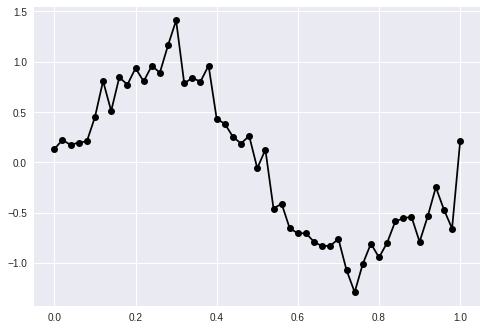

51

In [145]:
plt.plot(test_x.numpy(), test_y.numpy(), 'ko-')
plt.show()
test_x.shape[0]

Epoch: 0


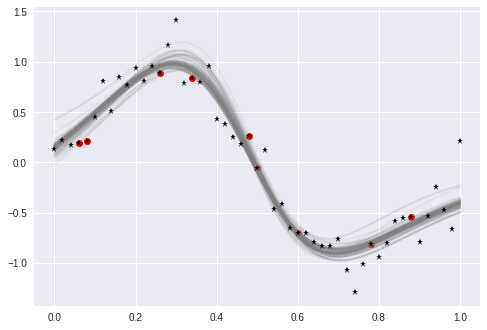

Training successful


In [158]:
epochs = 100

#TRAINING
for epoch in range(epochs):
    optimizer.zero_grad()
    
    
    # select number of context points randomly
    n_context = np.random.randint(1, 12)
    
    
    # select `n_context` points and create the context set and target set
    context_indeces = np.random.choice(test_x.shape[0], n_context, replace=False)
    x_c = test_x[context_indeces]
    y_c = test_y[context_indeces]
    x_t = test_x
    y_t = test_y

    
    # variational parameters (mean, std) of approximate prior
    z_mean_c, z_std_c = r_to_z(h(x_c, y_c))
    
    # variational parameters (mean, std) of approximate posterior
    z_mean_t, z_std_t = r_to_z(h(x_t, y_t))

    #train1
#     log_likelihood = nep.MC_loglikelihood(x_t, y_t, g, z_mean_t, z_std_t, 10)
    KL = nep.KL_div(z_mean_t, z_std_t, z_mean_c, z_std_c) 
#     ELBO = - log_likelihood + KL
#     kl.append(KL)
#     elbo.append(ELBO)
#     ELBO.backward()
#     optimizer.step()   
    
    #train2
    z = nep.sample_z(z_mean_t, z_std_t, how_many=1)
    y_pred, _ = g(x_t, z)
    output = loss(y_pred, y_t) + KL
    compare.append(output)
    output.backward()
    optimizer.step()   
    
    
    
    if epoch % 1000 == 0:
        print('Epoch:', epoch)
        y_pred = nep.predict(test_x, g, z_mean_t, z_std_t, 100)

        # Plot of sample functions
        plt.plot(x_c.numpy(), y_c.numpy(), 'ro')
        for i in y_pred:
            plt.plot(test_x.numpy(), i, 'grey', alpha=0.1) 
        plt.plot(test_x.numpy().flatten(), test_y.numpy().flatten(), 'k*')
        
        plt.show()
        
        
print('Training successful')

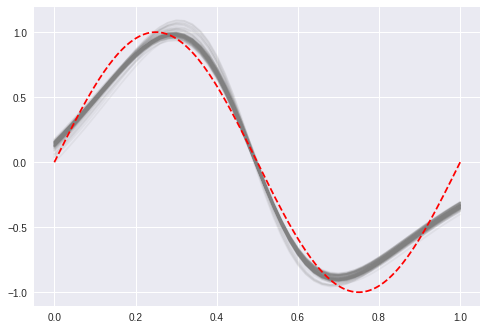

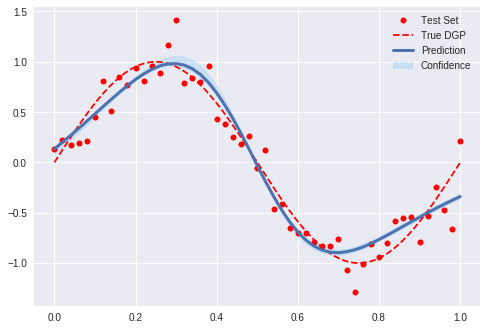

In [159]:
y_pred = nep.predict(test_x, g, z_mean_t, z_std_t, 100)
quantile_05, median, quantile_95 = np.percentile(y_pred, [5, 50, 95], axis=0)

# Plot of sample functions
for i in y_pred:
    plt.plot(test_x.numpy(), i, 'grey', alpha=0.1)   
plt.plot(truth_x.numpy(), truth_y.numpy(), 'r--')
plt.show()
    
    
# Plot of distribution over functions
#plt.plot(train_x.numpy(), train_y.numpy(), 'ro')
plt.plot(test_x.numpy().flatten(), test_y.numpy().flatten(), 'ro', markersize=6)
plt.plot(truth_x.numpy(), truth_y.numpy(), 'r--')
plt.plot(test_x.numpy().flatten(), median.flatten(), '-', linewidth=3)
plt.fill_between(test_x.numpy().flatten(), quantile_05.flatten(), quantile_95.flatten(), alpha=0.15, facecolor='#089FFF')
plt.legend(['Test Set', 'True DGP', 'Prediction', 'Confidence'])
plt.show()

In [0]:
state_list = []
state_list.append(optimizer.state_dict())
state_list.append(g.state_dict())
state_list.append(h.state_dict())
state_list.append(r_to_z.state_dict())


In [0]:
j = 0
for i in state_list:
    j += 1
    torch.save(i, 'mimmo' + str(j) + '.txt')

In [150]:
import os
os.getcwd()

'/content'

In [151]:
os.listdir()

['.config',
 'mimmo2.txt',
 'neural_process.py',
 'mimmo3.txt',
 '.ipynb_checkpoints',
 'mimmo1.txt',
 '__pycache__',
 'mimmo4.txt',
 'sample_data']